# Tabular data
In the "Further Research" section of chapter 9 of the book, the 1st assignment is to pick a competition on Kaggle based on tabular data. I chose to join the [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/overview/description). This competion was closed years ago, but the open ones are all about predicting sales and I don't want to simply replicate what was in the book.

In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import matplotlib.pyplot as plt

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Set up the Kaggle API and get the data:

In [3]:
creds = '{"username":"francescolost","key":"b1cc19c1a43064e643fa0eabbc4ebffe"}'

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
print(cred_path)
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

/root/.kaggle/kaggle.json


In [5]:
path = URLs.path('tabularplayground')
path

Path('/root/.fastai/archive/tabularplayground')

In [6]:
Path.BASE_PATH = path

In [7]:
from kaggle import api

In [8]:
if not path.exists():
    path.mkdir(parents=True)

In [9]:
api.competition_download_cli('bike-sharing-demand', path=path)

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
path.ls()

(#4) [Path('sampleSubmission.csv'),Path('test.csv'),Path('train.csv'),Path('bike-sharing-demand.zip')]

In [11]:
file_extract(path/'bike-sharing-demand.zip')

In [12]:
path.ls(file_type='text')

(#3) [Path('sampleSubmission.csv'),Path('test.csv'),Path('train.csv')]

In [13]:
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)

In [14]:
len(df_train.columns),len(df_test.columns)

(12, 9)

In [15]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [16]:
df_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [17]:
df_train.drop(columns=['registered','casual'],inplace=True)

In [18]:
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
count           int64
dtype: object

Merge in a single dataframe for better handling:

In [19]:
df = pd.concat([df_train, df_test], axis=0)

In [20]:
df['is_test'] = 0
df.loc[ df['count'].isna(), 'is_test' ] = 1

Get additional info out of `datetime`:


In [21]:
add_datepart??

In [22]:
df = add_datepart(df, 'datetime', time=True)

In [23]:
for c in df.columns:
  print(c,':', len(df[c].unique()), ':', df[c].unique())

season : 4 : [1 2 3 4]
holiday : 2 : [0 1]
workingday : 2 : [0 1]
weather : 4 : [1 2 3 4]
temp : 50 : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.   40.18]
atemp : 65 : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455  0.    46.21  47.725 49.24  50.   ]
humidity : 89 : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64 

In [24]:
df.drop(columns=['datetimeMinute','datetimeSecond'], inplace=True)

Create a validation set here: use the first 13 days of the month as training set and the days from 14th to 20th as validation set. The days from the 21st to the end of the month are already in the test set.

In [25]:
df['is_valid'] = 0
df.loc[ (df['datetimeDay'] > 13) & (df['is_test']==0), 'is_valid' ] = 1

In [26]:
df = df.astype({'datetimeWeek' : 'uint32'})

Probably it's better to treat `season` and `weather` as ordinal categories:

In [27]:
df['season'] = df['season'].astype('category')
df['season'].cat.set_categories([1,2,3,4], ordered=True, inplace=True)

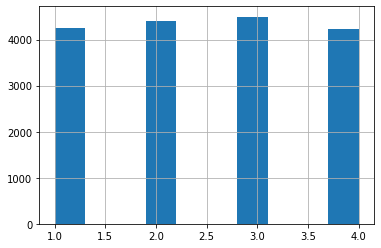

In [28]:
df['season'].hist();

In [29]:
df['weather'] = df['weather'].astype('category')
df['weather'].cat.set_categories([1,2,3,4], ordered=True, inplace=True)

The model is evaluated on the RMSLE:
$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $

In [30]:
targetVar = 'count'

In [31]:
df[ df['is_test']==0 ][targetVar].min(),df[ df['is_test']==0 ][targetVar].max()

(1.0, 977.0)

In [32]:
preds = np.random.random_integers(1,1000,len(df[df['is_valid']==1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 1000 + 1) instead
  """Entry point for launching an IPython kernel.


In [33]:
preds.min(),preds.max()

(1, 999)

In [34]:
L(list(preds))

(#3434) [103,436,861,271,107,72,701,21,615,122...]

In [35]:
def rmsle(p,a):
  return np.sqrt( ((np.log(p+1) - np.log(a+1))**2).mean() )

In [36]:
def m_rmsle(m, xs, y): return rmsle(m.predict(xs), y)

In [37]:
rmsle(preds, df[ df['is_valid']==1 ][targetVar])

2.144815193903836

In [38]:
preds.shape,df[ df['is_valid']==1 ][targetVar].shape

((3434,), (3434,))

In [39]:
#F.mse_loss( np.log(preds), np.log(df[ df['is_valid']==1 ][targetVar].values) )
math.sqrt(F.mse_loss( torch.tensor(np.log(preds+1)), torch.tensor(np.log(df[ df['is_valid']==1 ][targetVar].values+1)) ))

2.144815193903836

The same metric can be easily obtained using "standard" torch functions :)

Build a `TabularPandas` object:

In [40]:
df_train = df[ df['is_test']==0 ]

cond = df_train['is_valid']==0
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [41]:
[ (c,df[c].dtype) for c in df.columns ]

[('season', CategoricalDtype(categories=[1, 2, 3, 4], ordered=True)),
 ('holiday', dtype('int64')),
 ('workingday', dtype('int64')),
 ('weather', CategoricalDtype(categories=[1, 2, 3, 4], ordered=True)),
 ('temp', dtype('float64')),
 ('atemp', dtype('float64')),
 ('humidity', dtype('int64')),
 ('windspeed', dtype('float64')),
 ('count', dtype('float64')),
 ('is_test', dtype('int64')),
 ('datetimeYear', dtype('int64')),
 ('datetimeMonth', dtype('int64')),
 ('datetimeWeek', dtype('uint32')),
 ('datetimeDay', dtype('int64')),
 ('datetimeDayofweek', dtype('int64')),
 ('datetimeDayofyear', dtype('int64')),
 ('datetimeIs_month_end', dtype('bool')),
 ('datetimeIs_month_start', dtype('bool')),
 ('datetimeIs_quarter_end', dtype('bool')),
 ('datetimeIs_quarter_start', dtype('bool')),
 ('datetimeIs_year_end', dtype('bool')),
 ('datetimeIs_year_start', dtype('bool')),
 ('datetimeHour', dtype('int64')),
 ('datetimeElapsed', dtype('float64')),
 ('is_valid', dtype('int64'))]

Convert boolean features to numeric:

In [42]:
for c in [ i for i in df.columns if 'Is' in i ]:
  df[c] = df[c].astype(int)

In [43]:
def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        
        # mod to detect ProductSize type properly
        if (df[label].dtype.name == 'category'):
          cat_names.append(label)
          continue

        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [44]:
cont,cat = cont_cat_split(df, max_card=100, dep_var=targetVar)

`Categorify` is not used as there are no string-typed columns

In [45]:
procs = [Categorify,FillMissing]

In [46]:
to = TabularPandas(df_train, procs=procs, cat_names=cat, cont_names=cont, y_names=targetVar, splits=splits)

In [47]:
to.show(5)

,season,holiday,workingday,weather,humidity,is_test,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,is_valid,temp,atemp,windspeed,datetimeDayofyear,datetimeElapsed,count
0,1,0,0,1,81,0,2011,1,52,1,5,False,True,False,True,False,True,0,0,9.84,14.395,0.0,1,1.293840e+09,16.0
1,1,0,0,1,80,0,2011,1,52,1,5,False,True,False,True,False,True,1,0,9.02,13.635,0.0,1,1.293844e+09,40.0
2,1,0,0,1,80,0,2011,1,52,1,5,False,True,False,True,False,True,2,0,9.02,13.635,0.0,1,1.293847e+09,32.0
3,1,0,0,1,75,0,2011,1,52,1,5,False,True,False,True,False,True,3,0,9.84,14.395,0.0,1,1.293851e+09,13.0
4,1,0,0,1,75,0,2011,1,52,1,5,False,True,False,True,False,True,4,0,9.84,14.395,0.0,1,1.293854e+09,1.0


In [48]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Use a function to quickly build a Random Forest:

In [49]:
def rf(xs,y,n_estimators=40,max_samples=5000,max_features=0.5,min_samples_leaf=10,**kwargs):
  return RandomForestRegressor(n_jobs=-1,
                               n_estimators=n_estimators,max_samples=max_samples,max_features=max_features,
                               min_samples_leaf=min_samples_leaf,oob_score=True).fit(xs,y)

In [50]:
m = rf(xs,y)

In [51]:
m_rmsle(m, xs, y),m_rmsle(m, valid_xs, valid_y)

(0.45392649585848865, 0.4831370897451352)

In [52]:
rmsle(m.oob_prediction_,y)

0.49482989043274356

Interestingly the OOB error is slightly *higher* than the validation error!

Let's check the variance of the predictions:

In [53]:
valid_xs.shape

(3434, 24)

In [54]:
preds = np.stack([ t.predict(valid_xs) for t in m.estimators_ ])
preds.shape

(40, 3434)

A row for each estimator, a column for each element in the validation set

In [55]:
preds_std = preds.std(0)
preds_std.shape

(3434,)

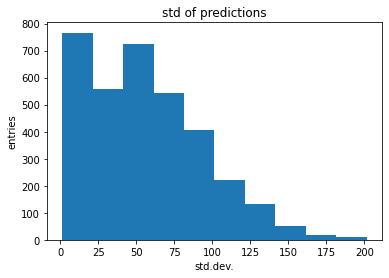

In [56]:
plt.figure()
plt.title('std of predictions');
plt.hist(preds_std);

plt.xlabel('std.dev.');
plt.ylabel('entries');

Feature importance

In [57]:
def rf_feature_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp',ascending=False)

In [58]:
fi = rf_feature_importance(m, xs)
fi[:10]

,cols,imp
17,datetimeHour,0.570839
23,datetimeElapsed,0.116983
20,atemp,0.080792
19,temp,0.047741
4,humidity,0.041366
6,datetimeYear,0.030669
10,datetimeDayofweek,0.030259
2,workingday,0.027248
22,datetimeDayofyear,0.020830
3,weather,0.009987


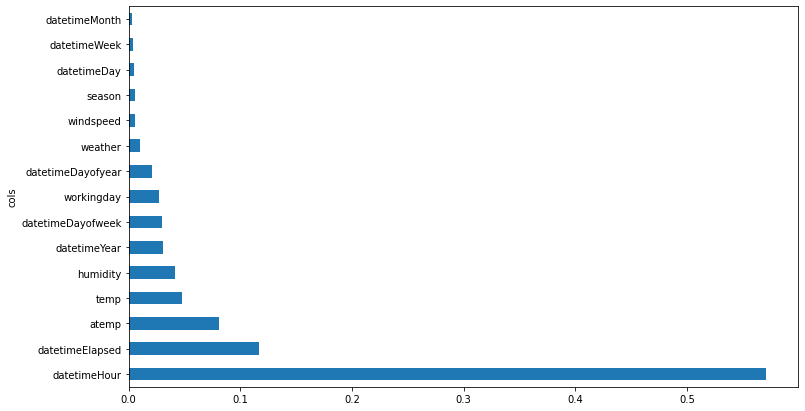

In [59]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:15]);

Filter out low-importance features:

In [60]:
to_keep = fi[ fi['imp'] > 0.005 ].cols.tolist()
len(fi), len(to_keep)

(24, 12)

In [61]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [62]:
m = rf(xs_imp, y)

In [63]:
m_rmsle(m, xs_imp, y), m_rmsle(m, valid_xs_imp, valid_y)

(0.4472790882731053, 0.46951513111532195)

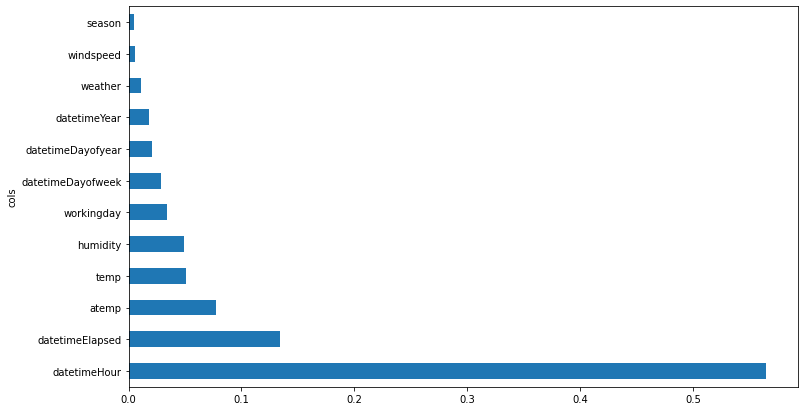

In [64]:
plot_fi(rf_feature_importance(m, xs_imp));

Remove redundant features

In [65]:
discarded = list(set(xs.columns) - set(to_keep))

In [66]:
discarded

['datetimeIs_month_end',
 'datetimeIs_year_end',
 'is_test',
 'datetimeIs_year_start',
 'datetimeIs_quarter_end',
 'holiday',
 'datetimeIs_quarter_start',
 'is_valid',
 'datetimeMonth',
 'datetimeDay',
 'datetimeIs_month_start',
 'datetimeWeek']

In [67]:
to_keep + [discarded[0]]

['datetimeHour',
 'datetimeElapsed',
 'atemp',
 'temp',
 'humidity',
 'datetimeYear',
 'datetimeDayofweek',
 'workingday',
 'datetimeDayofyear',
 'weather',
 'windspeed',
 'season',
 'datetimeIs_month_end']

In [68]:
[ i for i in discarded if not (('Is' in i) or ('is' in i)) ]

['holiday', 'datetimeMonth', 'datetimeDay', 'datetimeWeek']

In [69]:
xs['datetimeIs_month_end'].unique()

array([1], dtype=int8)

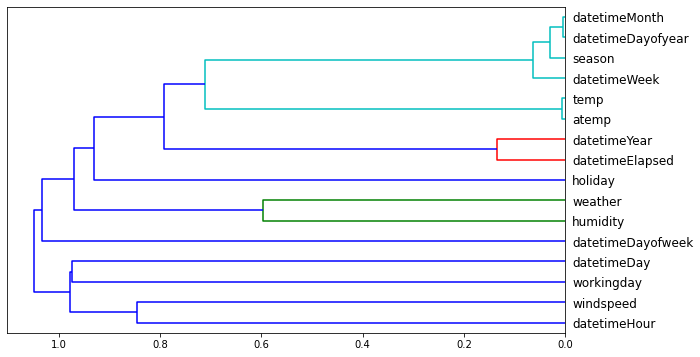

In [70]:
cluster_columns(xs[to_keep + [ i for i in discarded if not (('Is' in i) or ('is' in i)) ]])

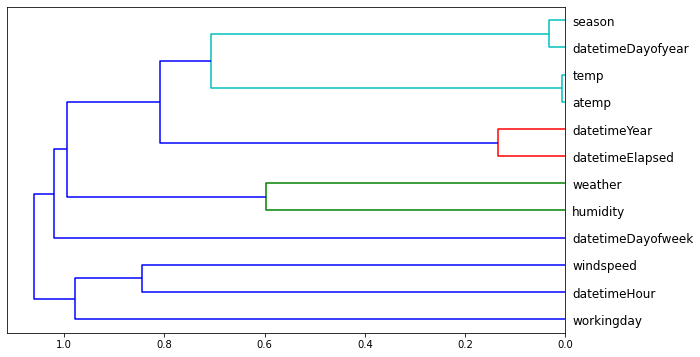

In [71]:
cluster_columns(xs_imp)

In [72]:
to_drop = ['temp']
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [73]:
m = rf(xs_final, y)

In [74]:
m_rmsle(m, xs_final, y), m_rmsle(m, valid_xs_final, valid_y)

(0.46629821285923345, 0.48872751778609774)

Check out of domain data

In [75]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [76]:
m = rf(df_dom, is_valid)
rf_feature_importance(m, df_dom)

,cols,imp
7,datetimeDayofyear,0.567100
1,datetimeElapsed,0.273541
2,atemp,0.045467
10,season,0.040753
3,humidity,0.024823
5,datetimeDayofweek,0.012444
9,windspeed,0.010953
4,datetimeYear,0.010541
0,datetimeHour,0.007052
8,weather,0.003813


In [77]:
m = rf(xs_final, y)
print('orig', m_rmsle(m, valid_xs_final, valid_y))

for c in ('datetimeDayofyear','datetimeElapsed','atemp'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmsle(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.5098673737086222
datetimeDayofyear 0.4513123335683874
datetimeElapsed 0.46432538948655305
atemp 0.47006218924465276


Use a neural newtork!

In [78]:
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)

df_train.drop(columns=['registered','casual'],inplace=True)

df_nn = pd.concat([df_train, df_test], axis=0)

df_nn = add_datepart(df_nn, 'datetime', time=True)
df_nn.drop(columns=['datetimeMinute','datetimeSecond'], inplace=True)

df_nn['is_test'] = 0
df_nn.loc[ df_nn['count'].isna(), 'is_test' ] = 1

df_nn['is_valid'] = 0
df_nn.loc[ (df_nn['datetimeDay'] > 13) & (df_nn['is_test']==0), 'is_valid' ] = 1

df_nn['season'] = df_nn['season'].astype('category')
df_nn['season'].cat.set_categories([1,2,3,4], ordered=True, inplace=True)

df_nn['weather'] = df_nn['weather'].astype('category')
df_nn['weather'].cat.set_categories([1,2,3,4], ordered=True, inplace=True)

In [79]:
df_nn[targetVar] = np.log(df_nn[targetVar]+1)

In [80]:
df_input = df_nn[ df_nn['is_test']==0 ].reset_index()
cond = df_input['is_valid']==0
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [81]:
df_nn_final = df_input[list(xs_final.columns) + [targetVar]]

In [82]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=targetVar)

In [83]:
df_nn_final[cat_nn].nunique()

datetimeHour          24
humidity              89
datetimeYear           2
datetimeDayofweek      7
workingday             2
datetimeDayofyear    238
weather                4
season                 4
dtype: int64

In [84]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=targetVar)

In [85]:
to_nn.show()

,datetimeHour,humidity,datetimeYear,datetimeDayofweek,workingday,datetimeDayofyear,weather,season,datetimeElapsed,atemp,windspeed,count
0,0,81,2011,5,0,1,1,1,1.293840e+09,14.395000,0.0000,2.833213
1,1,80,2011,5,0,1,1,1,1.293844e+09,13.635000,0.0000,3.713572
2,2,80,2011,5,0,1,1,1,1.293847e+09,13.635000,0.0000,3.496508
3,3,75,2011,5,0,1,1,1,1.293851e+09,14.395000,0.0000,2.639057
4,4,75,2011,5,0,1,1,1,1.293854e+09,14.395000,0.0000,0.693147
5,5,75,2011,5,0,1,2,1,1.293858e+09,12.880000,6.0032,0.693147
6,6,80,2011,5,0,1,1,1,1.293862e+09,13.635000,0.0000,1.098612
7,7,86,2011,5,0,1,1,1,1.293865e+09,12.880000,0.0000,1.386294
8,8,75,2011,5,0,1,1,1,1.293869e+09,14.395000,0.0000,2.197225
9,9,76,2011,5,0,1,1,1,1.293872e+09,17.424999,0.0000,2.708050


In [86]:
dls = to_nn.dataloaders(1024)

In [87]:
y = to_nn.train.y
y.min(),y.max()

(0.6931471824645996, 6.885509490966797)

In [88]:
preds = torch.tensor(np.random.uniform(0,7,len(y)))
preds.shape

torch.Size([7452])

In [89]:
rmse(preds,torch.tensor(y.values))

TensorBase(2.7091)

In [93]:
torch.sqrt(F.mse_loss(preds,torch.tensor(y.values)))

tensor(2.7091, dtype=torch.float64)

In [98]:
def myrmse(preds, targs):
  return torch.sqrt(F.mse_loss(preds,targs))

In [99]:
myrmse(preds, torch.tensor(y.values))

tensor(2.7091, dtype=torch.float64)

In [100]:
learn = tabular_learner(dls, y_range=(0,7), layers=[500,250],
                        n_out=1, loss_func=myrmse)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0008317637839354575)

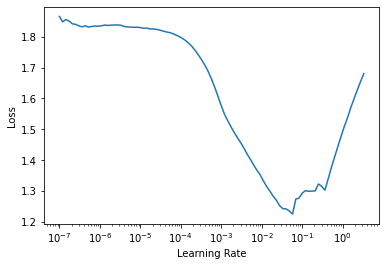

In [101]:
learn.lr_find()

In [102]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,time
0,1.539838,1.730491,00:00
1,1.103575,1.469885,00:00
2,0.861155,1.296496,00:00
3,0.701637,1.273910,00:00
4,0.594699,1.271471,00:00
